In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from mordred import Calculator, descriptors

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [5]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

**Чтение данных**

In [6]:
def chunk_read_csv(file_path : str, chunk_size: int):
    df = pd.DataFrame()
    with pd.read_csv(file_path, chunksize=chunk_size) as reader:
        df = pd.concat(reader)
    return df

In [7]:
# Загрузка таблицы
file_path = 'data/SMILES_Big_Data_Set.csv'
df = chunk_read_csv(file_path, chunk_size=200)
df

,SMILES,pIC50,mol,num_atoms,logP
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26,<rdkit.Chem.rdchem.Mol object at 0x7f59df45bc30>,25,4.15910
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c9e0>,36,3.67430
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cac0>,23,1.53610
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cba0>,22,0.95100
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c7b0>,21,3.21300
...,...,...,...,...,...
16082,S=C(NN=C(c1ccccn1)c1ccccn1)Nc1ccccc1,0.00,<rdkit.Chem.rdchem.Mol object at 0x7f59a314ed50>,24,3.21560
16083,S=C=NCCCCCCCCCCc1ccccc1,0.00,<rdkit.Chem.rdchem.Mol object at 0x7f59a314edc0>,19,5.45270
16084,S=C=NCCCCCCCCc1ccccc1,0.00,<rdkit.Chem.rdchem.Mol object at 0x7f59a314ee30>,17,4.67250
16085,S=c1[nH]nc(Cn2ccc3ccccc32)n1-c1ccccc1,0.00,<rdkit.Chem.rdchem.Mol object at 0x7f59a314eea0>,22,3.93289


**Информация о данных**

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16087 entries, 0 to 16086
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SMILES     16087 non-null  object 
 1   pIC50      15037 non-null  float64
 2   mol        16087 non-null  object 
 3   num_atoms  16087 non-null  int64  
 4   logP       16087 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 628.5+ KB


In [9]:
df.describe()

,pIC50,num_atoms,logP
count,15037.000000,16087.000000,16087.000000
mean,0.998739,18.749984,2.256600
std,2.479588,8.428888,1.609861
min,0.000000,3.000000,-5.395600
25%,0.000000,13.000000,1.214900
50%,0.010000,17.000000,2.163200
75%,0.130000,23.000000,3.232440
max,10.970000,85.000000,15.879200


**Поиск пропущенных значений**

In [10]:
na_values = df.isna().sum()
na_values[na_values > 0]

pIC50    1050
dtype: int64

Пропущенно 1050 значений в столбце 'plC50' (т.е. 1050 значений в столбце 'pIC50' == NaN)

Удалим эти вещества, содержащие пустые значения. В дальнейшем они могут помешать кластеризации

In [11]:
df = df.dropna()

Или же можно добавить всем им флаг, что это вещество содержит неизвестное значение PIC50 (но это влияет на кластеризацию)

In [ ]:
# Создаем бинарный флаг для пропущенных значений (0 - не пропущен, 1 - пропущен)
df.insert(2, 'pIC50_missing', df['pIC50'].isna().astype(int), True)
# Заменяем пропуски специальным значением (вне нормального диапазона)
df['pIC50'] = df['pIC50'].fillna(-999)

In [12]:
df.head()

,SMILES,pIC50,mol,num_atoms,logP
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26,<rdkit.Chem.rdchem.Mol object at 0x7f59df45bc30>,25,4.1591
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c9e0>,36,3.6743
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cac0>,23,1.5361
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cba0>,22,0.9510
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c7b0>,21,3.2130


**Проверка на уникальность**

In [13]:
# duplicates = df[df.duplicated(subset=['SMILES'], keep=False)].drop('mol', axis=1)
duplicates = df[df.duplicated(subset=['SMILES'], keep=False)]
duplicates_sorted = duplicates.sort_values(by='SMILES')
print(f"Кол-во неуникальных SMILES: {duplicates_sorted['SMILES'].unique().shape[0]}")
duplicates_sorted

Кол-во неуникальных SMILES: 179


,SMILES,pIC50,mol,num_atoms,logP
1128,C=CC1(O)CCC(n2cc(C(N)=O)c(Nc3ccc(Cl)cc3)n2)C(C...,7.60,<rdkit.Chem.rdchem.Mol object at 0x7f59a2952500>,27,3.16088
1517,C=CC1(O)CCC(n2cc(C(N)=O)c(Nc3ccc(Cl)cc3)n2)C(C...,8.22,<rdkit.Chem.rdchem.Mol object at 0x7f59a295d0e0>,27,3.16088
1889,CC(=O)N1CCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1,10.40,<rdkit.Chem.rdchem.Mol object at 0x7f59a29674c0>,24,2.05260
1865,CC(=O)N1CCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1,10.03,<rdkit.Chem.rdchem.Mol object at 0x7f59a2966a40>,24,2.05260
162,CC(=O)NC1CCc2ccc(Oc3cnc4[nH]cc(C(=O)NC(C)C)c4n...,5.77,<rdkit.Chem.rdchem.Mol object at 0x7f59a31dfa70>,29,3.01180
...,...,...,...,...,...
757,[C-]#[N+]C1CC(OCC2CC2)CCC1n1cc(C(N)=O)c(Nc2ccn...,7.12,<rdkit.Chem.rdchem.Mol object at 0x7f59a2948190>,29,3.06779
569,[C-]#[N+]C1CC(OCC2CC2)CCC1n1cc(C(N)=O)c(Nc2ccn...,6.82,<rdkit.Chem.rdchem.Mol object at 0x7f59a2942e30>,29,3.06779
1419,[C-]#[N+]C1CC(OCC2CC2)CCC1n1cc(C(N)=O)c(Nc2ccn...,8.05,<rdkit.Chem.rdchem.Mol object at 0x7f59a295a570>,29,3.06779
643,[C-]#[N+]C1CCCCC1n1cc(C(N)=O)c(Nc2ccc(CC(=O)O)...,6.96,<rdkit.Chem.rdchem.Mol object at 0x7f59a2944f20>,27,2.75569


Всего в этой таблице 395 вещств, имеющих дубликаты SMILES с другими значениями в остальных столбцах

Давайте посмотрим, какие значения различаются в этих столбцах

In [14]:
# Группировка и подсчет кол-ва различий в каждом столбце для каждого SMILES
grouped = duplicates.groupby('SMILES').agg({
    'pIC50': 'nunique',
    'num_atoms': 'nunique',
    'logP': 'nunique',
    'mol' : 'nunique'
}).reset_index()

conflicts = {
    'pIC50': grouped[grouped['pIC50'] > 1],
    'num_atoms': grouped[grouped['num_atoms'] > 1],
    'logP': grouped[grouped['logP'] > 1],
    'mol': grouped[grouped['mol'] > 1],
    # 'other': grouped[grouped['pIC50'] == 1 & grouped['num_atoms'] == 1 & grouped['logP'] == 1 & grouped['mol'] == 1],
}

print(f"SMILES с противоречиями в pIC50: {conflicts['pIC50'].shape[0]}")
print(f"SMILES с противоречиями в num_atoms: {conflicts['num_atoms'].shape[0]}")
print(f"SMILES с противоречиями в logP: {conflicts['logP'].shape[0]}")
print(f"SMILES с противоречиями в mol: {conflicts['mol'].shape[0]}")
grouped

SMILES с противоречиями в pIC50: 153
SMILES с противоречиями в num_atoms: 0
SMILES с противоречиями в logP: 0
SMILES с противоречиями в mol: 179


,SMILES,pIC50,num_atoms,logP,mol
0,C=CC1(O)CCC(n2cc(C(N)=O)c(Nc3ccc(Cl)cc3)n2)C(C...,2,1,1,2
1,CC(=O)N1CCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1,2,1,1,2
2,CC(=O)NC1CCc2ccc(Oc3cnc4[nH]cc(C(=O)NC(C)C)c4n...,2,1,1,2
3,CC(=O)c1ccc(Nc2nn(C3CCC(N4CCC4)CC3C#N)cc2C(N)=...,2,1,1,2
4,CC(C)(C(=O)O)c1ccc(Nc2nn(C3CCC(N4CCC4)CC3C#N)c...,2,1,1,2
...,...,...,...,...,...
174,O=[N+]([O-])c1ccc(O)c([N+](=O)[O-])c1,1,1,1,2
175,O=c1[nH]c2cnc(-n3cnc4ccccc43)nc2n1C1CCOc2c(F)c...,3,1,1,3
176,[C-]#[N+]C1CC(N2CCC2)CCC1n1cc(Nc2ccc(OC(F)F)nc...,2,1,1,2
177,[C-]#[N+]C1CC(OCC2CC2)CCC1n1cc(C(N)=O)c(Nc2ccn...,3,1,1,3


Из последнего следует, что есть такие молекулы, у которых все свойства совпадают, кроме адреса в библиотеке RdKit и значения pIC50 (т.е. в данных нет таких дубликатов веществ, где было бы отличие в num_atoms и logP )

In [15]:
grouped[grouped['mol'] > grouped['pIC50']].shape

(29, 5)

In [16]:
df[df['SMILES'] == 'O=C(O)CNCP(=O)(O)O']

,SMILES,pIC50,mol,num_atoms,logP


29 SMILES, где отличается только столбец mol

In [17]:
# Тут совпадает все, кроме значений в столбце 'mol'
duplicates_sorted[duplicates_sorted['SMILES'] == 'CCCC(=O)O']

,SMILES,pIC50,mol,num_atoms,logP
3479,CCCC(=O)O,0.13,<rdkit.Chem.rdchem.Mol object at 0x7f59a2993290>,6,0.8711
2966,CCCC(=O)O,0.13,<rdkit.Chem.rdchem.Mol object at 0x7f59a2985070>,6,0.8711


Удалим дубликаты, где отличается только столбец mol

In [18]:
drop_df = df.drop_duplicates(subset=['SMILES', 'pIC50'], keep='first')

In [19]:
undrop_df = df
df = drop_df

In [ ]:
# df.to_csv('../data/data_withMissFlag_fill-999_and_duplicates.csv', index=False)

In [21]:
df.to_csv('data/data_withDropNA_and_duplicates.csv', index=False)

---

### Преобразование данных

Добавим численные значение из библиотеки RDKit

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from mordred import Calculator, descriptors

In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

In [5]:
def chunk_read_csv(file_path : str, chunk_size: int):
    df = pd.DataFrame()
    with pd.read_csv(file_path, chunksize=chunk_size) as reader:
        df = pd.concat(reader)
    return df

In [9]:
# Загрузка таблицы
# file_path = '../data/data_withMissFlag_fill-999_and_duplicates.csv'
file_path = '../data/data_withDropNA_and_duplicates.csv'
df = chunk_read_csv(file_path, chunk_size=200)
df

,SMILES,pIC50,mol,num_atoms,logP
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26,<rdkit.Chem.rdchem.Mol object at 0x7f59df45bc30>,25,4.15910
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c9e0>,36,3.67430
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cac0>,23,1.53610
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cba0>,22,0.95100
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c7b0>,21,3.21300
...,...,...,...,...,...
15000,S=C(NN=C(c1ccccn1)c1ccccn1)Nc1ccccc1,0.00,<rdkit.Chem.rdchem.Mol object at 0x7f59a314ed50>,24,3.21560
15001,S=C=NCCCCCCCCCCc1ccccc1,0.00,<rdkit.Chem.rdchem.Mol object at 0x7f59a314edc0>,19,5.45270
15002,S=C=NCCCCCCCCc1ccccc1,0.00,<rdkit.Chem.rdchem.Mol object at 0x7f59a314ee30>,17,4.67250
15003,S=c1[nH]nc(Cn2ccc3ccccc32)n1-c1ccccc1,0.00,<rdkit.Chem.rdchem.Mol object at 0x7f59a314eea0>,22,3.93289


In [10]:
# Преобразование SMILES в RDKit Mol объекты
df["nmol"]            = df["SMILES"].apply(Chem.MolFromSmiles)
df["MolecularWeight"] = df["nmol"].apply(lambda mol: Descriptors.MolWt(mol))
df["HBD"]             = df["nmol"].apply(lambda mol: rdMolDescriptors.CalcNumHBD(mol))
df["HBA"]             = df["nmol"].apply(lambda mol: rdMolDescriptors.CalcNumHBA(mol))
df["TPSA"]            = df["nmol"].apply(lambda mol: Descriptors.TPSA(mol))
df["RotatableBonds"]  = df["nmol"].apply(lambda mol: Descriptors.NumRotatableBonds(mol))
df["NumRings"]        = df["nmol"].apply(lambda mol: Descriptors.RingCount(mol))

In [11]:
df.head()

,SMILES,pIC50,mol,num_atoms,logP,nmol,MolecularWeight,HBD,HBA,TPSA,RotatableBonds,NumRings
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26,<rdkit.Chem.rdchem.Mol object at 0x7f59df45bc30>,25,4.1591,<rdkit.Chem.rdchem.Mol object at 0x000001A3A7F...,367.455,1,5,71.95,4,4
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c9e0>,36,3.6743,<rdkit.Chem.rdchem.Mol object at 0x000001A3A7F...,506.434,4,6,149.78,7,5
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cac0>,23,1.5361,<rdkit.Chem.rdchem.Mol object at 0x000001A3A7F...,317.389,3,5,101.37,5,3
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cba0>,22,0.9510,<rdkit.Chem.rdchem.Mol object at 0x000001A3A7F...,301.394,3,5,98.96,5,3
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c7b0>,21,3.2130,<rdkit.Chem.rdchem.Mol object at 0x000001A3A7F...,294.383,2,3,49.84,2,3


In [12]:
calc = Calculator(descriptors)

In [13]:
%%time

chunk_size = 500
num_chunks = len(df) // chunk_size + 1
mordred_descs = []
for i in range(0, num_chunks):
    mordred_descs.append(calc.pandas(df.nmol[chunk_size*i : chunk_size*(i + 1)], quiet=True, ipynb=True))
    print(f"Посчитан чанк {i} из {num_chunks}, размер чанка {chunk_size}")
mordred_desc = pd.concat(mordred_descs)

Посчитан чанк 0 из 31, размер чанка 500
Посчитан чанк 1 из 31, размер чанка 500
D:\ProgramingPrograms\Python\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
Посчитан чанк 2 из 31, размер чанка 500
D:\ProgramingPrograms\Python\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
Посчитан чанк 3 из 31, размер чанка 500
Посчитан чанк 4 из 31, размер чанка 500
Посчитан чанк 5 из 31, размер чанка 500
Посчитан чанк 6 из 31, размер чанка 500
Посчитан чанк 7 из 31, размер чанка 500
Посчитан чанк 8 из 31, размер чанка 500
Посчитан чанк 9 из 31, размер чанка 500
Посчитан чанк 10 из 31, размер чанка 500
Посчитан чанк 11 из 31, размер чанка 500
D:\ProgramingPrograms\Python\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, a

In [16]:
mordred_desc.shape

(15005, 1088)

**Преобразование типов**

В новых данных некоторые столбцы имеют тип object, хотя в них содержаться числовые данные.

Чтобы не терять эти данные преобразуем тип object к типу float и удалим столбцы, где есть пустые значения (или что-то непонятное, например, выводы ошибки при вычислении дескриптора)

In [21]:
# Преобразуем проблемные столбцы
for col in mordred_desc.columns:
    if mordred_desc[col].dtype == object:
        mordred_desc[col] = pd.to_numeric(mordred_desc[col], errors='coerce')

# Заменяем бесконечные значения
# df = df.replace([np.inf, -np.inf], np.nan)

# Удаляем столбцы с >50% пропусков
# mordred_des = mordred_desc.dropna(axis=1, thresh=len(mordred_desc)*0.5)
mordred_desc = mordred_desc.dropna(axis=1)
mordred_desc.shape

(15005, 1088)

---
---
---

In [22]:
# Сохраним дескрипторы для тестов
mord_desc_test = mordred_desc 

In [23]:
# Сохраним данные со SMILES
dft = df.drop(columns=['mol', 'nmol'])

In [24]:
dft_values = dft.drop(columns=['SMILES'])

In [25]:
dft.head()

,SMILES,pIC50,num_atoms,logP,MolecularWeight,HBD,HBA,TPSA,RotatableBonds,NumRings
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26,25,4.1591,367.455,1,5,71.95,4,4
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34,36,3.6743,506.434,4,6,149.78,7,5
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53,23,1.5361,317.389,3,5,101.37,5,3
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56,22,0.9510,301.394,3,5,98.96,5,3
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59,21,3.2130,294.383,2,3,49.84,2,3


**Уменьшение размерности**

In [26]:
%%time

# Рассчет корреляционной матрицы
corr_matrix = mord_desc_test.corr(numeric_only=True).abs()

CPU times: total: 10.6 s
Wall time: 35.6 s


In [27]:
corr_matrix

,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
nAcid,1.000000,0.001224,0.011443,0.009289,0.001480,0.011443,0.093357,0.004406,0.001539,0.018575,...,0.002990,0.017166,0.000647,0.021778,0.009730,0.014158,0.009045,0.013816,0.051609,0.001629
nBase,0.001224,1.000000,0.214763,0.079772,0.082499,0.214763,0.080737,0.204854,0.179441,0.202258,...,0.142317,0.189857,0.201790,0.121461,0.178149,0.172016,0.203151,0.191438,0.159934,0.217466
SpAbs_A,0.011443,0.214763,1.000000,0.621867,0.629127,1.000000,0.425259,0.946337,0.903035,0.878731,...,0.807101,0.901620,0.953112,0.148552,0.855138,0.958472,0.989263,0.978201,0.846101,0.989559
SpMax_A,0.009289,0.079772,0.621867,1.000000,0.972578,0.621867,0.462199,0.759044,0.666907,0.739587,...,0.936002,0.730627,0.606283,0.033280,0.354722,0.719003,0.682827,0.715026,0.540940,0.566222
SpDiam_A,0.001480,0.082499,0.629127,0.972578,1.000000,0.629127,0.425917,0.772922,0.699580,0.758505,...,0.946343,0.664583,0.620227,0.031084,0.361629,0.730933,0.685658,0.713506,0.571119,0.581946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WPol,0.014158,0.172016,0.958472,0.719003,0.730933,0.958472,0.356373,0.916909,0.887528,0.836809,...,0.847159,0.879994,0.935643,0.082931,0.811610,1.000000,0.980795,0.987550,0.876395,0.939414
Zagreb1,0.009045,0.203151,0.989263,0.682827,0.685658,0.989263,0.388987,0.944153,0.907402,0.865556,...,0.842489,0.918942,0.954986,0.108590,0.842227,0.980795,1.000000,0.996935,0.863276,0.968858
Zagreb2,0.013816,0.191438,0.978201,0.715026,0.713506,0.978201,0.403243,0.935555,0.899850,0.851537,...,0.854374,0.923233,0.943014,0.095599,0.824549,0.987550,0.996935,1.000000,0.849359,0.950920
mZagreb1,0.051609,0.159934,0.846101,0.540940,0.571119,0.846101,0.017536,0.817235,0.790666,0.782896,...,0.708213,0.736556,0.902534,0.039675,0.786279,0.876395,0.863276,0.849359,1.000000,0.884271


In [28]:
# Удаление высоко коррелированных признаков
threshold = 0.95
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
mordred_desc_reduced = mord_desc_test.drop(to_drop, axis=1)

In [29]:
mordred_desc_reduced.shape

(15005, 580)

Удаление высоко коррелированных признаков:

0,95: (, 1088) -> (, 579) 

In [30]:
from sklearn.preprocessing import StandardScaler

# Стандартизация данных
scaler = StandardScaler()
scaled_features = scaler.fit_transform(mordred_desc_reduced)
scaled_features.shape

(15005, 580)

In [31]:
# Удаление почти-константных признаков (Удаление низковариативных признаков)
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=1e-5)
scaled_features = vt.fit_transform(scaled_features)
scaled_features.shape

(15005, 471)

In [32]:
from sklearn.decomposition import PCA

# PCA с сохранением 95% дисперсии
pca = PCA(n_components=100, svd_solver='randomized', random_state=42)
pca_features = pca.fit_transform(scaled_features)

# Создание DataFrame с компонентами
pca_df = pd.DataFrame(pca_features, columns=[f"PC_{i}" for i in range(pca_features.shape[1])])
pca_features.shape

(15005, 100)

In [33]:
# pca_df

In [39]:
# Подбор оптимального параметра n_components
np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95)

0

In [40]:
import umap

# Инициализация и применение UMAP
um = umap.UMAP(n_components=5) 
umap_features = um.fit_transform(pca_features)

# Создание DataFrame
umap_df = pd.DataFrame(umap_features, columns=[f"UMAP_{i}" for i in range(umap_features.shape[1])])
umap_features.shape

D:\ProgramingPrograms\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(15005, 5)

**Обучение модели**

In [41]:
scaled_dft_values = scaler.fit_transform(dft_values)

In [42]:
scaled_dft_values.shape

(15005, 9)

In [43]:
umap_features.shape

(15005, 5)

In [44]:
X = np.concatenate((dft_values, umap_features), axis=1)
X.shape

(15005, 14)

**Как оценить правильность кластеризации?**

**а) Метрики внутренней валидации**

Эти метрики не требуют знания истинных меток и оценивают "качество" кластеров на основе структуры данных:

1) **Силуэтный коэффициент (Silhouette Score):** <br>
Оценивает, насколько объект похож на свой кластер (когезия) и отличается от других (сепарация). <br>
**Интерпретация:** <br>
    \- Значение от -1 до 1. Чем ближе к 1, тем лучше. <br>
    \- Если $s(i) \approx 0$, объект находится на границе кластеров. <br>
    \- Отрицательные значения — признаки неудачной кластеризации. <br>
**Замечание:** <br>
Чем больше размер кластера (т.е. чем больше элементов в нем), тем точнее оценка, т.к. элемент будет содержаться в этом самом большом кластере 

3) **Индекс Дэвиса-Болдуина (Davies-Bouldin Index):** <br>
Среднее "сходство" между кластерами. Чем меньше значение, тем лучше разделены кластеры.
Формула:
$DB = \frac{1}{k}\sum_{i=1}^{k}{\max_{j \neq i}{(\dots)}}$ <br>
**Интерпретация:** <br>
    \- Чем ближе к 0, тем лучше. <br>
**Замечание:** <br>
Чем меньше элементов в кластере (кластер из одного элемента явл-ся самым оптимальным), тем точнее оценка, т.к. в этом кластере содержиться меньше элементов, которые могут отклонить "среднее значение". 


5) **Индекс Калинского-Харабаза (Calinski-Harabasz Index):** <br>
Отношение дисперсии между кластерами к дисперсии внутри кластеров. Чем выше значение, тем лучше. <br>
**Интерпретация:** <br>
    \- Чем выше значение, тем лучше. <br>
**Замечание:** <br>
Тоже самое, что для Силуэтный коэффициента. Дисперисия в кластере с одним элементов всегда меньше кластера с двумя элементами

In [45]:
# Оценки для k-means алгоритма

n_clast = (2, 30)

silhouette_scores = []
db_scores = []
ch_scores = []
inertias = []
for k in range(n_clast[0], n_clast[1]):
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(X)

    silhouette_scores.append(silhouette_score(X, labels))

    db_scores.append(davies_bouldin_score(X, labels))

    ch_scores.append(calinski_harabasz_score(X, labels))

    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

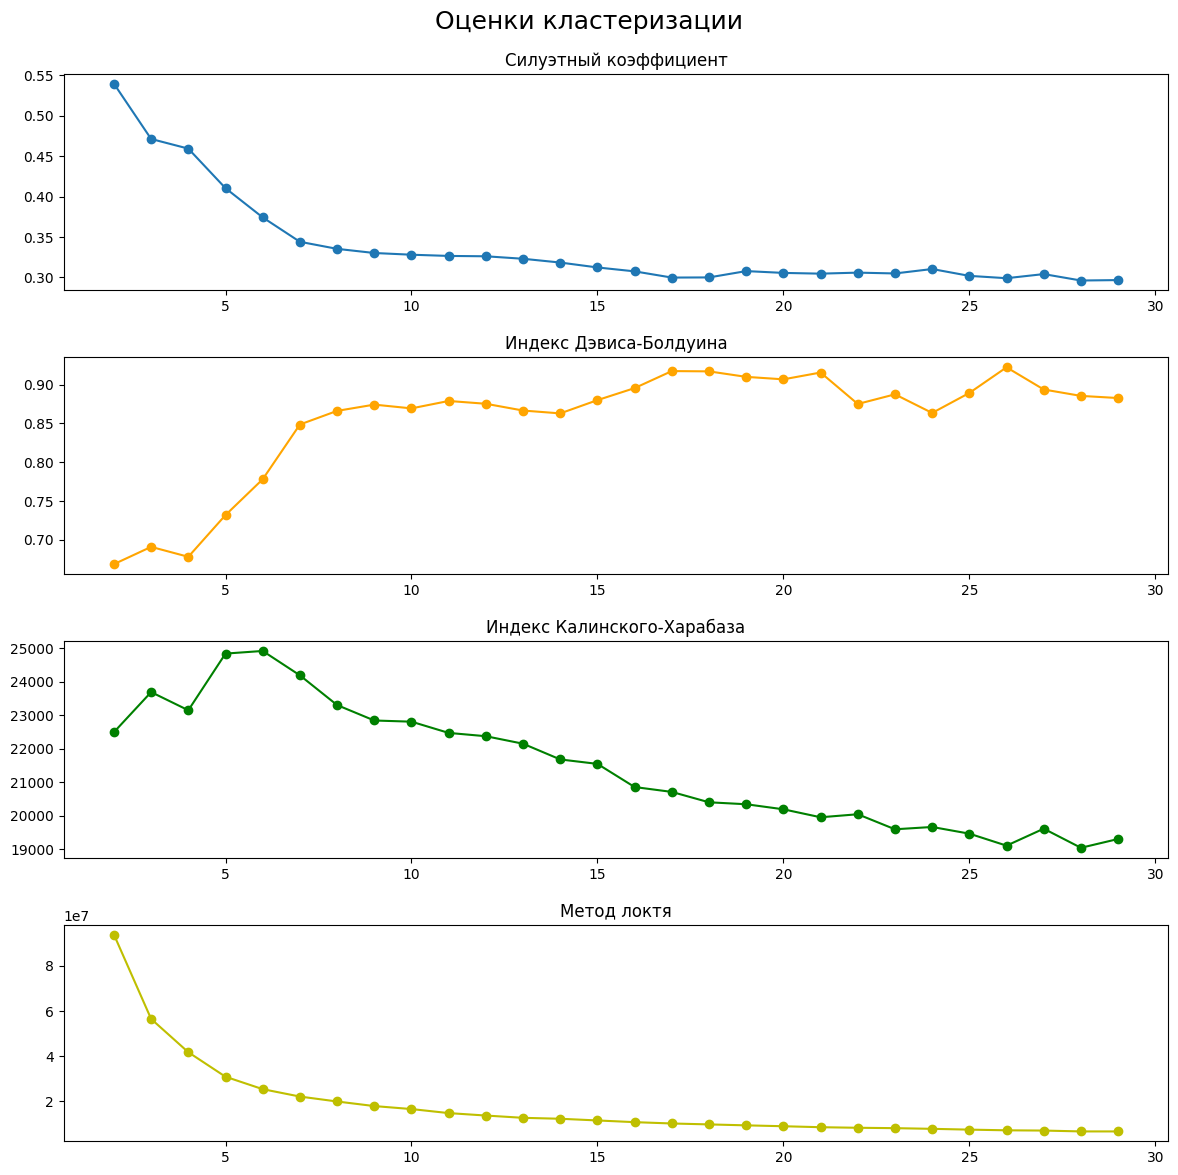

In [46]:
fig, ax = plt.subplots(4, figsize=(12, 12))
fig.suptitle('Оценки кластеризации', fontsize=18)
ax[0].plot(range(n_clast[0], n_clast[1]), silhouette_scores, marker='o')
ax[0].set_title('Силуэтный коэффициент')
ax[1].plot(range(n_clast[0], n_clast[1]), db_scores, marker='o', color='orange')
ax[1].set_title('Индекс Дэвиса-Болдуина')
ax[2].plot(range(n_clast[0], n_clast[1]), ch_scores, marker='o', color='g')
ax[2].set_title('Индекс Калинского-Харабаза')
ax[3].plot(range(n_clast[0], n_clast[1]), inertias, marker='o', color='y')
ax[3].set_title('Метод локтя')
fig.tight_layout(pad=1.5)
plt.show()

**HDBSCAN**

In [47]:
import hdbscan

# HDBSCAN
clusterer = hdbscan.HDBSCAN()
labels = clusterer.fit_predict(X)

# Оценки

sil = silhouette_score(X, labels)
db = davies_bouldin_score(X[labels != -1], labels[labels != -1])

print("sil:", sil, "db:", db, "n:", len(np.unique(labels)))
# print(np.unique(labels))

D:\ProgramingPrograms\Python\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\ProgramingPrograms\Python\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


sil: -0.3520171030934129 db: 0.7362836049248835 n: 573


**DBSCAN**

In [48]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Кластеризация
# dbscan = DBSCAN(eps=0, min_samples=100)
dbscan = DBSCAN(eps=0.5)
clusters_db = dbscan.fit_predict(X)

# Оценка качества (игнорируем шумовые точки)
if len(np.unique(clusters_db)) > 1:
    sil = silhouette_score(X[clusters_db != -1], clusters_db[clusters_db != -1])
    db = davies_bouldin_score(X[clusters_db != -1], clusters_db[clusters_db != -1])
    ch = calinski_harabasz_score(X[clusters_db != -1], clusters_db[clusters_db != -1])
    print("Силуэтный коэффициент:", sil, "\nИндекс Дэвиса-Болдуина:", db, "\nИндекс Калинского-Харабаза:", ch, "\nКол-во кластеров:", len(np.unique(clusters_db)))
else:
    print("Все данные отнесены к шуму или одному кластеру.")

Силуэтный коэффициент: 0.9781405192434545 
Индекс Дэвиса-Болдуина: 0.040832473167866264 
Индекс Калинского-Харабаза: 6294256.765967449 
Кол-во кластеров: 110


In [49]:
counts = np.bincount(clusters_db + 1, minlength=len(np.unique(clusters_db)) + 1)  # от -1 до 10 включительно = 12 чисел
counts

array([14212,     5,     5,     6,     5,     5,     5,     8,     5,
           5,     6,     5,     6,     6,     5,     6,     6,     6,
           5,     5,     7,     6,     6,     6,     5,     5,     9,
           5,     7,     7,     5,     6,     6,     5,     6,     8,
           7,     6,     6,     6,     5,     5,     6,     6,     5,
           6,     5,     6,     5,     5,     5,     7,     6,     5,
           7,     5,     6,    12,     6,     5,     5,    15,     9,
           6,     7,     5,     6,     5,     5,     5,     7,     6,
           5,     6,     5,     9,     6,    17,     6,     5,     5,
           5,     5,     5,     5,    12,     5,    24,    14,    16,
          30,    24,     8,     5,     5,    13,    16,     8,     6,
          18,     6,     8,     5,     9,    21,     6,     5,     6,
           5,     6,     0], dtype=int64)

Практически все элементы находятся в одном кластере

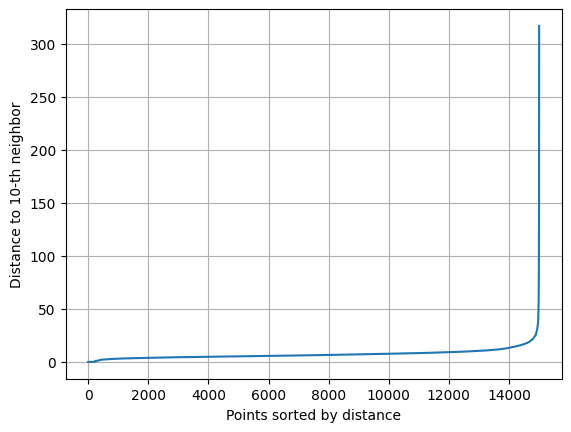

In [50]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# X_emb — матрица, на которой запускается DBSCAN (UMAP или PCA)
k = 10  # обычно = min_samples
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
distances, indices = nbrs.kneighbors(X)
k_distances = np.sort(distances[:, -1])  # расстояние до k-го соседа, отсортированное

plt.plot(k_distances)
plt.ylabel(f"Distance to {k}-th neighbor")
plt.xlabel("Points sorted by distance")
plt.grid(True)
plt.show()

In [56]:
def show_clusters_means(df, clusters):
    cluster_means = pd.DataFrame(df).groupby(clusters).mean()
    
    # Визуализация
    plt.figure(figsize=(12, 6))
    sns.heatmap(cluster_means.T, cmap='viridis', annot=True, fmt="3.1f")
    plt.title('Средние значения признаков по кластерам')
    plt.xlabel('Кластер')
    plt.ylabel('Признак')
    plt.show()

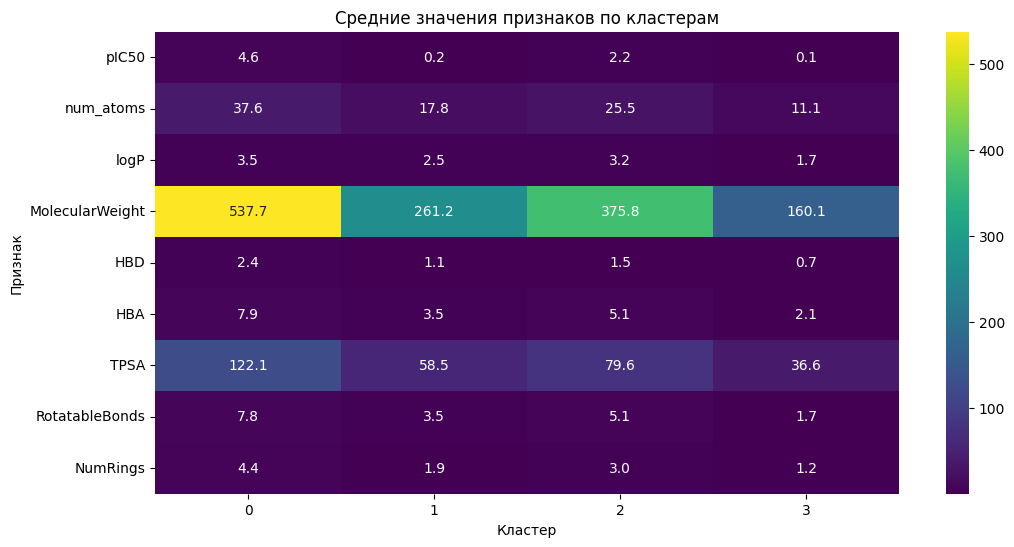

In [57]:
show_clusters_means(dft_values, labels)

**Дальнейшие действия**

Нужно как-то получить дескрипоры, которые мы оставили при уменьшении размерности 
Вроде бы эти столбцы сохраняются в виде свойства для каждого метода

scaler

varianceTreshHold

PCA

UMAP

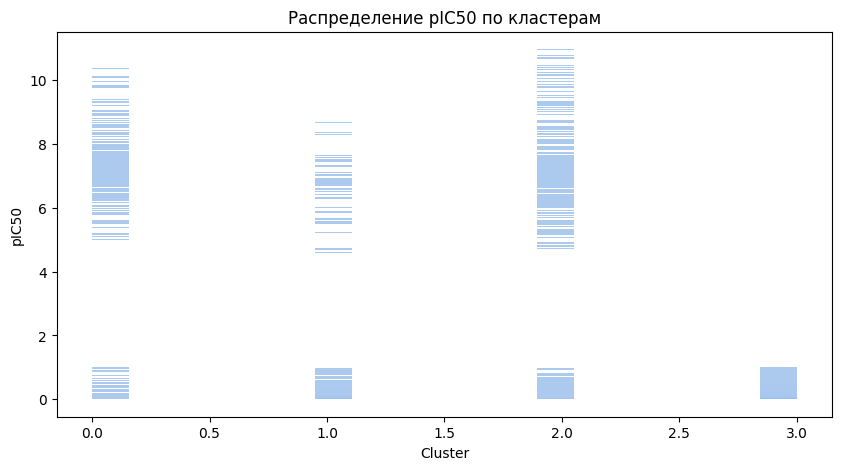

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(x="Cluster", y="pIC50", data=dft_result)
plt.title("Распределение pIC50 по кластерам")
plt.show()

Почему то присутствует неравномерное распределение св-ва pIC50. Обычно есть кластер где содержиться больше элементов чем в остальных

In [51]:
kmeans = KMeans(n_clusters=4)
labels = kmeans.fit_predict(X)
clusters_db_df = pd.DataFrame(labels, columns=["Cluster"])

In [53]:
clusters_db_df = pd.DataFrame(clusters_db.T, columns=["Cluster"])

In [52]:
dft_result = pd.concat([dft_values, clusters_db_df], axis=1)

In [56]:
dft_result

,pIC50,num_atoms,logP,MolecularWeight,HBD,HBA,TPSA,RotatableBonds,NumRings,Cluster
0,4.26,25,4.15910,367.455,1,5,71.95,4,4,2
1,4.34,36,3.67430,506.434,4,6,149.78,7,5,1
2,4.53,23,1.53610,317.389,3,5,101.37,5,3,2
3,4.56,22,0.95100,301.394,3,5,98.96,5,3,2
4,4.59,21,3.21300,294.383,2,3,49.84,2,3,2
...,...,...,...,...,...,...,...,...,...,...
15000,0.00,24,3.21560,333.420,2,4,62.20,4,3,2
15001,0.00,19,5.45270,275.461,0,2,12.36,11,1,4
15002,0.00,17,4.67250,247.407,0,2,12.36,9,1,4
15003,0.00,22,3.93289,306.394,1,4,38.54,3,4,2


In [279]:
dft_result.describe()

,pIC50,num_atoms,logP,MolecularWeight,HBD,HBA,TPSA,RotatableBonds,NumRings,Cluster
count,15005.000000,15005.000000,15005.000000,15005.000000,15005.000000,15005.000000,15005.000000,15005.000000,15005.000000,15005.000000
mean,0.995791,18.931490,2.465248,276.228444,1.139820,3.752016,61.236614,3.634722,2.100966,20.540953
std,2.475348,8.444723,1.441981,118.694703,1.118441,2.387376,37.665155,2.992135,1.377351,60.243524
min,0.000000,3.000000,-0.404900,40.065000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,13.000000,1.414200,189.174000,0.000000,2.000000,34.140000,1.000000,1.000000,-1.000000
50%,0.010000,17.000000,2.282800,257.318000,1.000000,3.000000,56.790000,3.000000,2.000000,-1.000000
75%,0.130000,23.000000,3.308900,343.415000,2.000000,5.000000,85.360000,5.000000,3.000000,-1.000000
max,10.970000,85.000000,15.879200,1202.635000,10.000000,20.000000,288.280000,32.000000,9.000000,284.000000
